In [2]:
import pandas as pd
import numpy as np
import os
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_path = './data/train.csv'
test_path = './data/test.csv'

In [4]:
train = pd.read_csv(train_path)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
train.datetime = pd.to_datetime(train.datetime)

In [11]:
test = pd.read_csv(test_path)

In [15]:
test.datetime = pd.to_datetime(test.datetime)

In [12]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [13]:
# 전처리 (Feature engineering)

train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [16]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

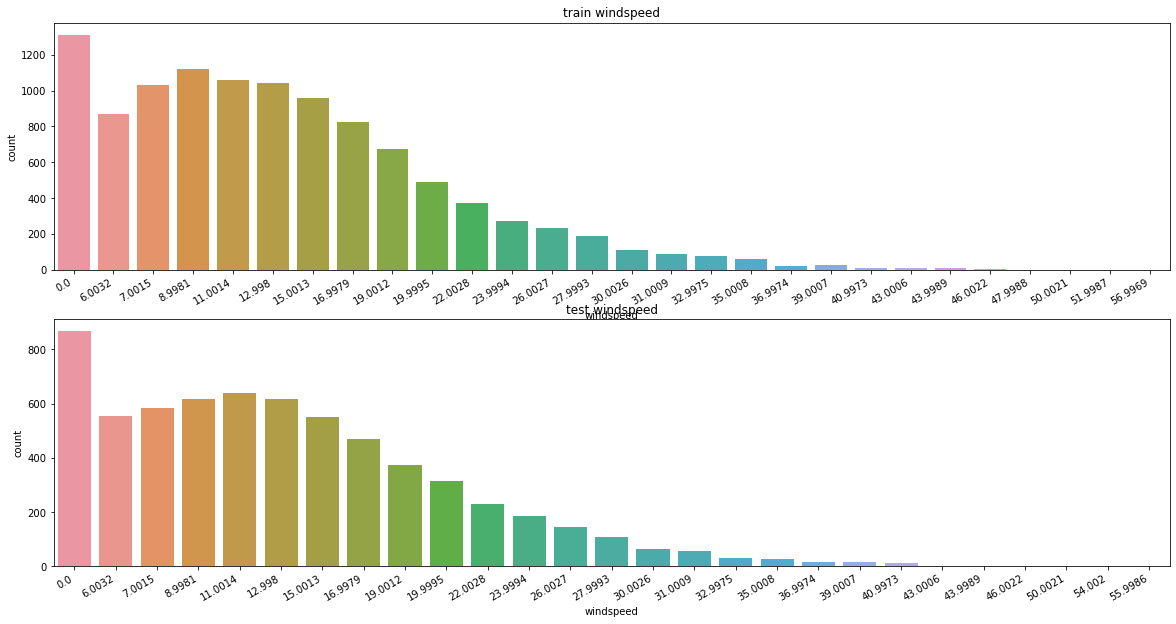

In [17]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(20,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title='test windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])


In [18]:
# 의식 흐름
# data.head() : widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
# 풍속의 0값에 특정 값을 넣어준다. fillna=0 처리할까?
# EDA 분석: countplot()으로 데이터시각화 >> 0으로 일괄처리시, 이상치 있는 것과 같게 되겠네
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.

In [23]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed']==0]
trainWindNot0 = train.loc[train['windspeed']!=0]

In [24]:
trainWind0.shape, trainWindNot0.shape

((1313, 19), (9573, 19))

In [30]:
#  머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()
    
    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

In [31]:
# 0값 처리해서 예측
train = predict_windspeed(train)
test = predict_windspeed(test)

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

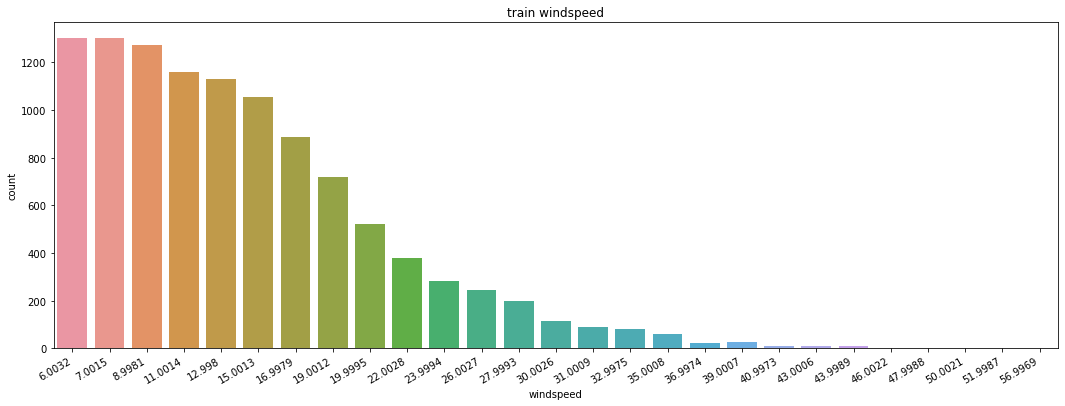

In [32]:
# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

In [33]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [35]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [36]:
train[feature_names]

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10881,4,2,16.40,20.455,87,8.9981,2012,12,0,0,1
10882,4,2,17.22,21.210,88,8.9981,2012,15,0,0,1
10883,4,1,15.58,19.695,94,6.0032,2012,8,1,0,1
10884,4,1,13.94,16.665,49,12.9980,2012,22,1,0,1


In [62]:
x_train  = train[feature_names]
x_train.shape

(10886, 11)

In [38]:
x_test  = test[feature_names]
x_test.shape

(6493, 11)

In [40]:
label_name = 'count'

y_train = train[label_name]

In [41]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 1을 더하는 이유는 0일때 마이너스 무한대가 되기 때문에 1을 더해주고 로그를 씌운다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [42]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [43]:
kfold = KFold(n_splits=10, shuffle=True, random_state=24)

In [44]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                             n_jobs=-1,
                             random_state=42)
model

RandomForestRegressor(n_jobs=-1, random_state=42)

In [45]:
%time score = cross_val_score(model, x_train, y_train, cv=kfold, scoring = rmsle_scorer)

Wall time: 29.2 s


In [48]:
score = score.mean()
score

0.3293663984429633

In [49]:
# 학습(train)

model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [50]:
# 예측

pred = model.predict(x_test)
print(pred)

[ 12.47   3.65   2.91 ... 206.85  60.58 187.58]


[Text(0.5, 1.0, 'test')]

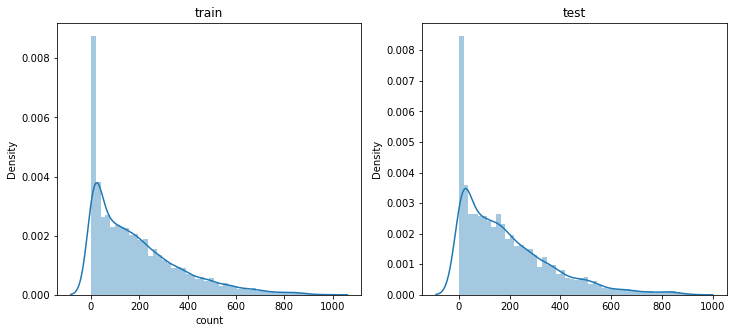

In [51]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(pred,ax=ax2,bins=50)
ax2.set(title="test")

In [64]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train) #log +1 
lModel.fit(x_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(x_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds)))

RMSLE Value For Linear Regression:  0.9798284781200242


### ridge 

#### 릿지 Regularization Model - Ridge

- 회귀를 위한 선형모델
- 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
- Regularization(정규화)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
- max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.


In [65]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( x_train, y_train_log )
preds = grid_ridge_m.predict(x_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds)))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9798284761079622


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031629,0.010356,0.011769,0.002916,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-0.264784,-0.204266,-0.249537,-0.202798,-0.239977,-0.232272,0.024769,1
1,0.016658,0.000976,0.010172,0.003115,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-0.264785,-0.204266,-0.249537,-0.202798,-0.239977,-0.232272,0.024769,2
2,0.018043,0.001741,0.007779,0.001324,1,3000,"{'alpha': 1, 'max_iter': 3000}",-0.264795,-0.204269,-0.249536,-0.202791,-0.239976,-0.232273,0.024773,3
3,0.015161,0.002915,0.006581,0.001494,2,3000,"{'alpha': 2, 'max_iter': 3000}",-0.264806,-0.204272,-0.249535,-0.202783,-0.239974,-0.232274,0.024777,4
4,0.012720,0.001955,0.005785,0.001467,3,3000,"{'alpha': 3, 'max_iter': 3000}",-0.264817,-0.204275,-0.249535,-0.202775,-0.239972,-0.232275,0.024780,5


In [66]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.232272
1,0.10,0.232272
2,1.00,0.232273
3,2.00,0.232274
4,3.00,0.232275


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

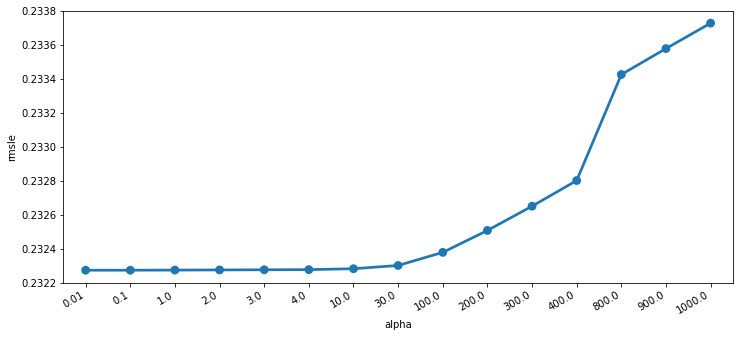

In [67]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### 라쏘 Regularization Model - Lasso

- 선형회귀의 Regularization(규제)를 적용하는 대안
- 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
- 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
- alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
- 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
- max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [71]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( x_train , y_train_log )
pred = grid_lasso_m.predict(x_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(pred)))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9798381214938896


,alpha,rmsle
0,10.000000,0.316789
1,1.000000,0.249640
2,0.500000,0.245344
3,0.333333,0.244172
4,0.250000,0.243621


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

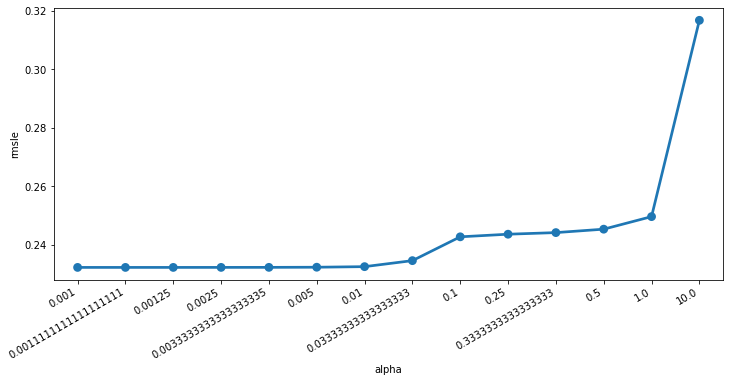

In [72]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [73]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(x_train, y_train_log)

pred = rfModel.predict(x_train)
score = rmsle(np.exp(y_train_log),np.exp(pred))
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10625410276435998


### 앙상블모델 - 그라디언트 부스트

#### Ensemble Model - Gradient Boost

* 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
* 회귀와 분류에 모두 사용할 수 있음
* 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
* 무작위성이 없고 강력한 사전 가지치기가 사용 됨
* 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
* learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
* n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
* max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.


In [74]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(x_train, y_train_log)

preds = gbm.predict(x_train)
score = rmsle(np.exp(y_train_log),np.exp(preds))
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.20429418157744855


<AxesSubplot:ylabel='Density'>

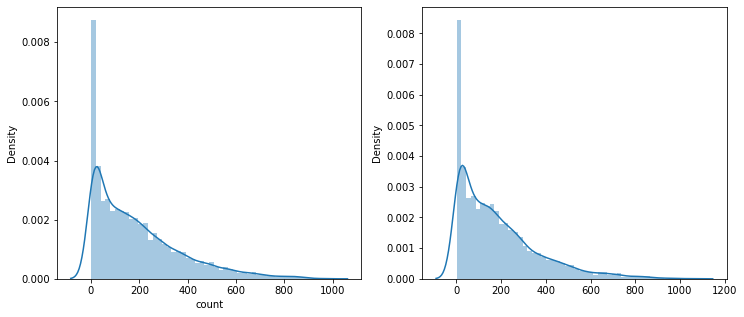

In [75]:
predsTest = gbm.predict(x_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)


In [ ]:
# submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/bike/sampleSubmission.csv")
# submission

# submission["count"] = np.exp(predsTest)  # log 함수 >> exp() 변환해야 원래 값으로 환원

# print(submission.shape)
# submission.head()
